# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import matplotlib.pyplot as plt
import seaborn as sb
import time

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .master("local") \
        .appName("Creating Features") \
        .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
# load dataset
stack_overflow_data = 'mini_sparkify_event_data.json'
df = spark.read.json(stack_overflow_data)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
print(df.count())
print(df.filter(df.sessionId == '').count())
print(df.filter(df.userId == '').count())

# clean dataset with empty userId
df = df.filter(df.userId != '')
print(df.count())

286500
0
8346
278154


`userId`列有`8346`个缺失值，总数据量为 `286500`，清洗之后还剩`278154`条数据。

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [5]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [6]:
churn = udf(lambda x: int(x == "Cancellation Confirmation"), IntegerType())
downgrade = udf(lambda x: int(x == "Downgrade"), IntegerType())

df = df.withColumn("churn", churn('page')).withColumn("downgrade", downgrade('page'))

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgrade: integer (nullable = true)



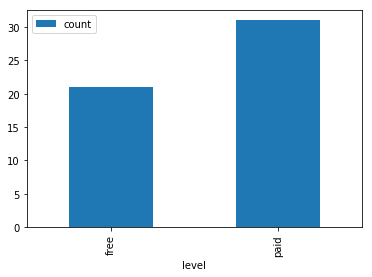

In [8]:
temp = df.filter(col('churn')==1).groupby('level').count().toPandas()

# 使用直方图探索churn与level的关系
temp.plot.bar(x='level');

流失用户中，付费用户占比更高，并没有像猜测的一样，免费用户比付费用户更易流失，但如果猜测付费用户比免费用户更容易流失也有点不符合常识。

In [9]:
temp = df.dropDuplicates(['userId', 'gender', 'churn']) \
        .groupby(['churn','gender']) \
        .count() \
        .sort('churn') \
        .toPandas()
temp.head()

,churn,gender,count
0,0,M,121
1,0,F,104
2,1,F,20
3,1,M,32


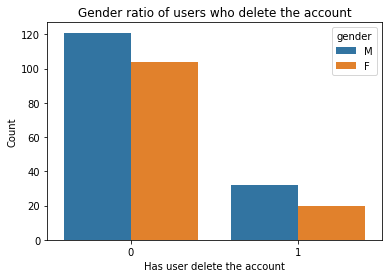

In [10]:
ax = sb.barplot(x = 'churn', y = 'count', hue = 'gender', data = temp)
plt.xlabel("Has user delete the account")
plt.ylabel("Count")
plt.title("Gender ratio of users who delete the account");

In [11]:
121/(121+104), 32/(32+20)

(0.5377777777777778, 0.6153846153846154)

相比来说，流失数据集中男性占比显著增大，总的来说，男性比女性用户更容易流失。

In [12]:
# 流失用户数， 降级用户数
print(df.filter(col('churn')==1).select('userId').dropDuplicates().count(),  \
df.filter(col('downgrade')==1).select('userId').dropDuplicates().count())

df_count = df.select('userId').dropDuplicates().count()
print(df_count)

print(df.filter(df.churn == 1).dropDuplicates().count() / df_count)

52 154
225
0.2311111111111111


流失用户大约占总用户数的 23.11%。

In [13]:
# 流失数据集
df_churn = df.filter(df.churn == 1)
# 留存数据集
df_keep = df.filter(df.churn == 0)

In [14]:
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [15]:
df_churn.filter(df_churn.auth=='Logged In').count()

0

In [16]:
df_keep.filter(df_keep.auth=='Logged In').count() == df_keep.count()

True

流失数据集中均为未注册用户，而留存数据集中均为注册用户。

In [17]:
df_churn.select('length').dropDuplicates().show()

+------+
|length|
+------+
|  null|
+------+



In [18]:
df_keep.agg({'length':'mean'}).show()

+-----------------+
|      avg(length)|
+-----------------+
|249.1171819778458|
+-----------------+



流失数据集中的`length`字段均为空值。

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [19]:
def feature_engineering(filepath):
    
    #dataframe of user ids to merge onto
    df = spark.read.json(filepath)
    users = df.where((df.userId != "") | (df.sessionId != ""))\
        .select('userId').dropDuplicates()
    
    #define custom functions
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
    visited_cancel = udf(lambda x: int(x=='Cancel'), IntegerType())
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
   
    home_visit=udf(lambda x : int(x=='Home'), IntegerType())

    
    numFriends = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends')
    
    #avg daily visits to help site
    dailyHelpVisit = df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
         .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

    
    #whether a user has downgraded
    churn = df.withColumn("downgraded", downgrade_churn("page"))\
        .withColumn("cancelled", churn("page"))\
        .withColumn('visited_cancel', visited_cancel('page'))\
        .withColumn('visited_downgrade', visited_downgrade('page'))\
        .select(['userId', 'downgraded', 'cancelled', 'visited_cancel', 'visited_downgrade'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgraded)', 'downgraded')\
        .withColumnRenamed('sum(cancelled)', 'cancelled')\
        .withColumnRenamed('sum(visited_cancel)', 'visited_cancel')\
        .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')

    cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', home_visit(col('page'))) \
        .withColumn('songPeriod', Fsum('homevisit').over(windowval))\
    
    avgSongsTillHome = cusum.filter((cusum.page=='NextSong'))\
        .groupBy('userId', 'songPeriod')\
        .agg({'songPeriod':'count'}).drop('songPeriod')\
        .groupby('userId').mean()\
        .withColumnRenamed('avg(count(songPeriod))', 'avgSongsTillHome')
    
    df = users.join(churn, on='userId')\
        .join(dailyHelpVisit, on='userId')\
        .join(numFriends, on='userId')\
        .join(avgSongsTillHome, on='userId')\
    
    return df

In [20]:
def feature_scaling(df):
    feature_cols = df.drop('userId', 'cancelled').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vec')
    
    #pyspark.ml expects target column to be names: 'labelCol', w/ type: Double
    df = df.withColumn("label", df["cancelled"].cast(DoubleType()))
    
    #pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [21]:
data_small = feature_engineering("mini_sparkify_event_data.json")
data_small = feature_scaling(data_small)
data_small.persist()

DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, numFriends: bigint, avgSongsTillHome: double, label: double, feature_vec: vector, features: vector]

In [23]:
train, rest = data_small.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

In [24]:
def custom_evaluation(pred, model_name):   
    # 查看结果
    # 时间也是衡量模型好坏的一个标准
    evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
    print(model_name)
    start = time.time()
    print("准确度: {}".format(evaluator.evaluate(pred, {evaluator.metricName:'accuracy'})))
    print("f1分数: {}".format(evaluator.evaluate(pred, {evaluator.metricName:'f1'})))
    end = time.time()
    print("验证集计算准确度与f1分数用时 {}秒".format(end - start))

In [25]:
rf = RandomForestClassifier(numTrees=10)
rf_model = rf.fit(train)
rf_preds = rf_model.transform(validation)
custom_evaluation(rf_preds, 'Random Forest')

Random Forest
准确度: 1.0
f1分数: 1.0
验证集计算准确度与f1分数用时 23.99507474899292秒


In [26]:
#SVM
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model=svm.fit(train)
svm_preds=svm_model.transform(validation)
custom_evaluation(svm_preds, 'Support Vector Machine')

Support Vector Machine
准确度: 1.0
f1分数: 1.0
验证集计算准确度与f1分数用时 19.415339708328247秒


In [27]:
#logistic regression model
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = logReg.fit(train)
lr_preds = lrModel.transform(validation)
custom_evaluation(lr_preds, 'Logistic Regression')

Logistic Regression
准确度: 0.6666666666666666
f1分数: 0.5333333333333334
验证集计算准确度与f1分数用时 21.316346883773804秒


综上所述，三种机器学习算法表现差不多，但表现都不好。

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。